In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import pymysql
from sqlalchemy import create_engine
import mysql.connector

from getpass import getpass


In [2]:
demo_path =r'..\Data\Raw\df_final_demo.txt'
final_experiment_path = r'..\Data\Raw\df_final_experiment_clients.txt'
final_web_data_1_path = r'..\Data\Raw\df_final_web_data_pt_1.txt'
final_web_data_2_path = r'..\Data\Raw\df_final_web_data_pt_2.txt'

In [3]:
demo_df = pd.read_csv(demo_path)

In [4]:
final_ex_clients_df = pd.read_csv(final_experiment_path)

In [5]:
final_web_1 = pd.read_csv(final_web_data_1_path)

In [6]:
final_web_2 = pd.read_csv(final_web_data_2_path)
final_web_df = pd.concat([final_web_1, final_web_2])


In [7]:
final_ex_clients_df['Variation'].value_counts(dropna=False)
final_ex_clients_df['Variation'].value_counts(dropna=False, normalize=True).apply(lambda x: f"{x:.2%}")
#removing null values from experiment file
final_ex_clients_df_clean = final_ex_clients_df.dropna()

In [8]:
def get_generation():
    """
    This function merges the demographic dataframe with the web dataframe to calculate the generation of each client:
    Extracts year from date_time (from web dataframe)
    Calculates year_born (year - age) -> rounded to 0 decimals
    Calculates generation by binning year_born up until 2018 (data ends in 2017)
    """
    merged_df = pd.merge(left=demo_df, right=final_web_df, how='inner', on='client_id')
    merged_df['date_time'] = pd.to_datetime(merged_df['date_time'])
    merged_df['year'] = merged_df['date_time'].dt.year
        
    gen_df = merged_df[['client_id', 'clnt_age', 'gendr', 'year']]
    gen_df = gen_df.groupby(['client_id', 'gendr']).agg(age = ('clnt_age', 'mean'), year = ('year', 'mean')).reset_index()
    gen_df['year_born'] = round(gen_df['year'] - gen_df['age'], 0)
    bins = [1925, 1945, 1964, 1980, 1996, 2018]
    labels = ['silent generation', 'baby boomers', 'generation x', 'millenial', 'generation z']
    gen_df['generation'] = pd.cut(gen_df['year_born'], bins = bins, labels = labels)
    gen_df = gen_df[['client_id', 'gendr', 'generation']]
    return gen_df

In [9]:
def get_variation(dataframe):
    dataframe_clean = dataframe['client_id'].isin(final_ex_clients_df_clean['client_id'])
    #adding Variation column to web path file by merging with experiment file. This will enable us to calculate KPIs for both groups. 
    dataframe_clean = pd.merge(final_ex_clients_df_clean, dataframe, on='client_id')
    #defining test and control group
    return dataframe_clean

In [10]:
def get_group(dataframe): 
    test_group = dataframe[dataframe['Variation']=='Test']
    control_group = dataframe[dataframe['Variation']=='Control']

    return test_group, control_group

In [11]:
clnt_gen_df = get_generation()
demo_df_clean = get_variation(demo_df)
clnt_gen_df_clean = get_variation(clnt_gen_df)
final_web_df_clean = get_variation(final_web_df)

In [12]:
def get_distribution_meassure_numerical(dataframe, column_name):
    """
    Returns mean, median, mode, var, std, range and quantiles for the given column of dataframe
    Also shows a historigram

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the numerical column to analyze.

    Returns (not implemented):
        mean (int).
        median (int).
        mode (int).
        variation (int).
        standard deviation (int).
        range (int): calculated by the following formula dataframe[column_name].max() - dataframe[column_name].min()
        quantiles (pd.Dataframe).

    """
    mean = dataframe[column_name].mean()
    median = dataframe[column_name].median()
    mode = dataframe[column_name].mode()[0]
    var = dataframe[column_name].var()
    std = dataframe[column_name].std()

    d_min = dataframe[column_name].min()
    d_max = dataframe[column_name].max()
    d_range = d_max - d_min

    quantiles = dataframe[column_name].quantile([0.25, 0.50, 0.75])

    print('------------------------')
    print(f'distribution meassures for {column_name}')
    print('------------------------')
    print(f""""
    mean is {mean}
    median is {median}
    mode is {mode}
    var is {var}
    std is {std}
    max is {d_max} and min is {d_min}
    range is {d_range}
    quantiles are {quantiles}
    """)
    
    sns.histplot(dataframe[column_name], kde=True, color='salmon')
    plt.show()


In [13]:
def get_bar_plot(column_x, column_y):
    """
    returns bar plot
    """
    sns.barplot(x = column_x,
            y = column_y,
            palette='Set2',
            hue = column_x)

    plt.xticks(rotation=70, fontsize=9)
    plt.show()

In [14]:
def get_frequencies(dataframe, column_name = ''):
    """
    Returns frequency and proportion tables for the given column of dataframe
    Also displays a bar plot for the frequency table.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to analyze.

    Returns (not implemented):
        frequency_table (pd.Series): Count of each category.
        proportion_table (pd.Series): Proportion of each category.
    """

    if 'gendr' in dataframe.columns:
        m_mask = dataframe['gendr'] == 'M'
        f_mask = dataframe['gendr'] == 'F'
        column_name = 'gendr'
    
    masked_categorical_df = dataframe[m_mask | f_mask]
    frequency_table = masked_categorical_df[column_name].value_counts()

    proportion_table = masked_categorical_df[column_name].value_counts(normalize=True).apply(lambda x: f"{x:.2%}")
    

    print(frequency_table)
    print (proportion_table)

    get_bar_plot(column_x= frequency_table.index, column_y=frequency_table.values)

In [15]:
def get_frequencies_null_values(dataframe, column_name):
    """
    Returns frequency and proportion tables for the given column of dataframe
    Also displays a bar plot for the frequency table.

    Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to analyze.

    Returns (not implemented):
        frequency_table (pd.Series): Count of each category.
        proportion_table (pd.Series): Proportion of each category.
    """
    if 'gendr' in dataframe.columns:
        m_mask = dataframe['gendr'] == 'M'
        f_mask = dataframe['gendr'] == 'F'
        column_name = 'gendr'
    
    masked_categorical_df = dataframe[m_mask | f_mask]
    frequency_table = masked_categorical_df[column_name].value_counts(dropna=False)

    proportion_table = masked_categorical_df[column_name].value_counts(dropna=False, normalize=True).apply(lambda x: f"{x:.2%}")

    print(frequency_table)
    print (proportion_table)
    get_bar_plot(column_x= frequency_table.index.astype(str), column_y=frequency_table.values)

In [16]:
def get_demographics(dataframe):
   """
   1. Observe which columns are numerical and which are categorical:
   2. Are there any columns that are numerical but can be considered categorical?
   3. Which are continuous and which are ordinal observations
   4. Proceed with the analysis

   Parameters:
   dataframe (pd.DataFrame)

   Returns:
   0. numerical_df (pd.DataFrame)
   1. categorical_df (pd.DataFrame)
   """

   numerical_df = dataframe.select_dtypes('number')
   categorical_df = dataframe.select_dtypes('object')

   #Drop client id as it is not relevant for analysis
   numerical_df.drop('client_id', axis=1, inplace=True)
   display(numerical_df, categorical_df)
   get_frequencies(dataframe)
   for column in numerical_df.columns:
      get_distribution_meassure_numerical(numerical_df, column)

   return numerical_df, categorical_df

In [ ]:
get_demographics(demo_df_clean)

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
0,5.0,64.0,79.0,2.0,189023.86,1.0,4.0
1,22.0,274.0,34.5,2.0,36001.90,5.0,8.0
3,6.0,80.0,44.5,2.0,30231.76,1.0,4.0
5,11.0,137.0,27.0,2.0,46131.19,1.0,4.0
6,21.0,254.0,53.5,2.0,192109.59,6.0,9.0
...,...,...,...,...,...,...,...
50490,19.0,238.0,26.5,2.0,35887.12,0.0,3.0
50492,14.0,179.0,60.5,3.0,85826.90,4.0,7.0
50497,6.0,74.0,62.0,2.0,58778.11,2.0,5.0
50498,23.0,278.0,30.5,2.0,61349.70,0.0,3.0


,Variation,gendr
0,Test,U
1,Test,M
3,Test,U
5,Test,F
6,Test,F
...,...,...
50490,Test,F
50492,Test,F
50497,Test,M
50498,Test,M


gendr
M    8977
F    8716
Name: count, dtype: int64
gendr
M    50.74%
F    49.26%
Name: proportion, dtype: object


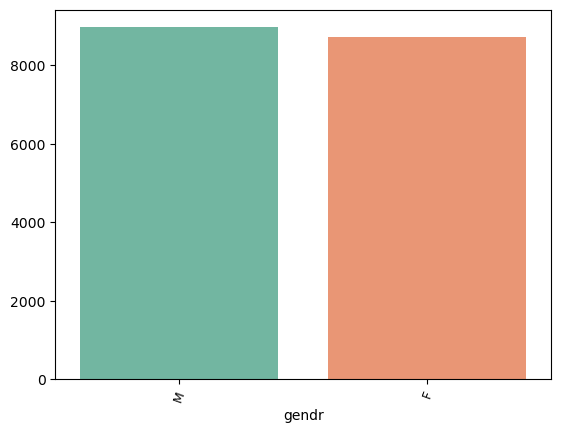

------------------------
distribution meassures for clnt_tenure_yr
------------------------
"
    mean is 11.98290122769927
    median is 11.0
    mode is 5.0
    var is 46.85330554398289
    std is 6.844947446400366
    max is 55.0 and min is 2.0
    range is 53.0
    quantiles are 0.25     6.0
0.50    11.0
0.75    15.0
Name: clnt_tenure_yr, dtype: float64
    


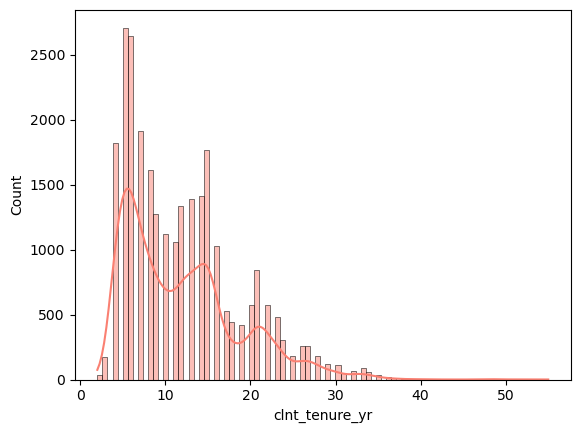

------------------------
distribution meassures for clnt_tenure_mnth
------------------------
"
    mean is 149.8528986313564
    median is 134.0
    mode is 58.0
    var is 6688.522870770555
    std is 81.7833899442335
    max is 669.0 and min is 33.0
    range is 636.0
    quantiles are 0.25     82.0
0.50    134.0
0.75    191.0
Name: clnt_tenure_mnth, dtype: float64
    


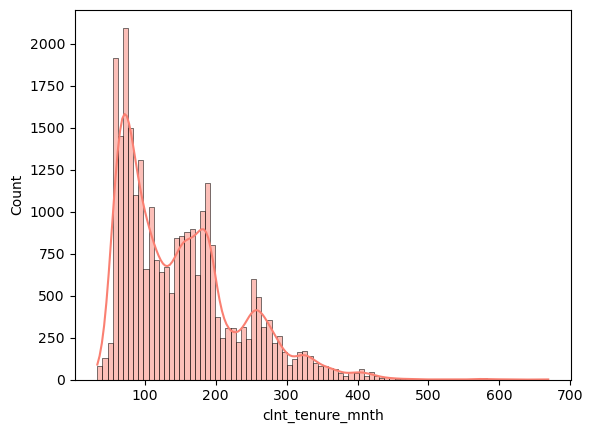

------------------------
distribution meassures for clnt_age
------------------------
"
    mean is 47.16392196135158
    median is 47.5
    mode is 29.5
    var is 240.6984902407949
    std is 15.514460681596216
    max is 96.0 and min is 17.0
    range is 79.0
    quantiles are 0.25    33.5
0.50    47.5
0.75    59.5
Name: clnt_age, dtype: float64
    


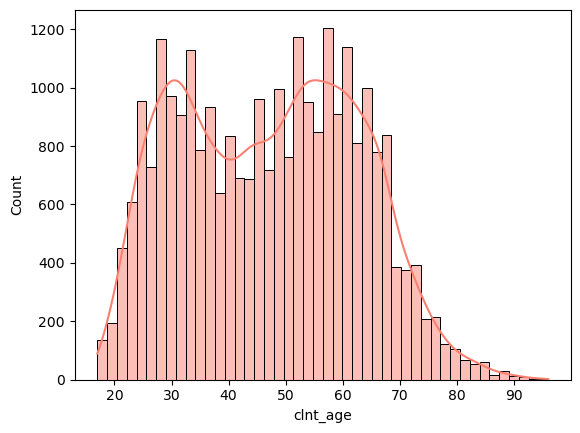

------------------------
distribution meassures for num_accts
------------------------
"
    mean is 2.2499165461221766
    median is 2.0
    mode is 2.0
    var is 0.2801951896226605
    std is 0.5293346669382807
    max is 7.0 and min is 1.0
    range is 6.0
    quantiles are 0.25    2.0
0.50    2.0
0.75    2.0
Name: num_accts, dtype: float64
    


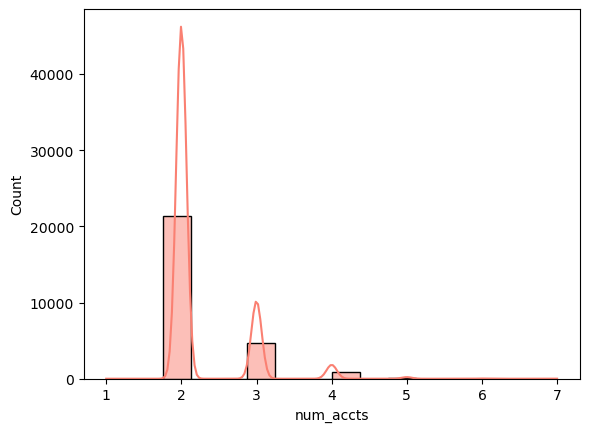

------------------------
distribution meassures for bal
------------------------
"
    mean is 148962.6050317125
    median is 65468.36
    mode is 29389.11
    var is 94478599919.82713
    std is 307373.7137749862
    max is 16320040.15 and min is 23789.44
    range is 16296250.71
    quantiles are 0.25     39729.20
0.50     65468.36
0.75    139478.58
Name: bal, dtype: float64
    


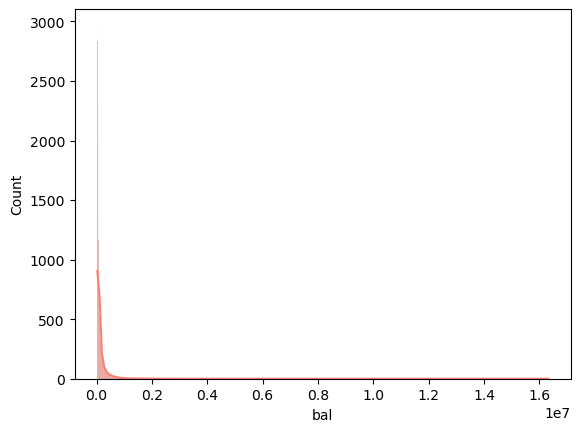

------------------------
distribution meassures for calls_6_mnth
------------------------
"
    mean is 3.061941322651237
    median is 3.0
    mode is 6.0
    var is 4.798685385429082
    std is 2.1905901911195262
    max is 6.0 and min is 0.0
    range is 6.0
    quantiles are 0.25    1.0
0.50    3.0
0.75    5.0
Name: calls_6_mnth, dtype: float64
    


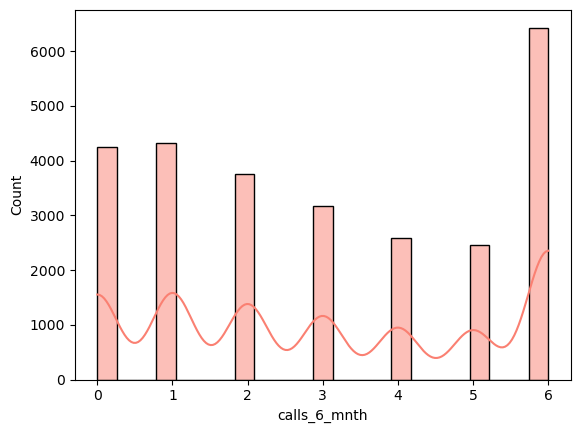

------------------------
distribution meassures for logons_6_mnth
------------------------
"
    mean is 6.101850821557064
    median is 6.0
    mode is 9.0
    var is 4.739848577299679
    std is 2.1771193300551257
    max is 9.0 and min is 3.0
    range is 6.0
    quantiles are 0.25    4.0
0.50    6.0
0.75    8.0
Name: logons_6_mnth, dtype: float64
    


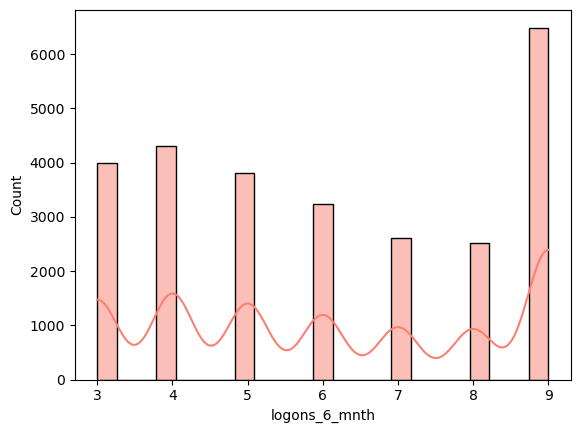

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,num_accts,bal,calls_6_mnth,logons_6_mnth
2,12.0,149.0,63.5,2.0,142642.26,5.0,8.0
4,5.0,70.0,29.0,2.0,34254.54,0.0,3.0
7,13.0,162.0,56.5,2.0,324712.88,4.0,7.0
9,6.0,74.0,61.5,2.0,39795.28,1.0,4.0
12,12.0,149.0,32.5,2.0,33807.15,1.0,4.0
...,...,...,...,...,...,...,...
50491,7.0,87.0,31.5,2.0,106927.60,0.0,4.0
50493,27.0,334.0,50.0,3.0,464879.31,2.0,5.0
50494,18.0,226.0,63.5,3.0,89726.65,2.0,5.0
50495,15.0,191.0,52.5,2.0,60344.67,1.0,4.0


,Variation,gendr
2,Control,M
4,Control,U
7,Control,M
9,Control,U
12,Control,F
...,...,...
50491,Control,M
50493,Control,F
50494,Control,F
50495,Control,M


gendr
M    7970
F    7543
Name: count, dtype: int64
gendr
M    51.38%
F    48.62%
Name: proportion, dtype: object


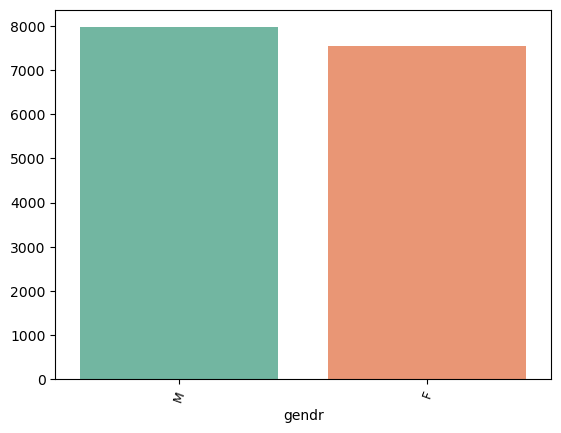

------------------------
distribution meassures for clnt_tenure_yr
------------------------
"
    mean is 12.087686487865007
    median is 11.0
    mode is 6.0
    var is 47.30043793146166
    std is 6.8775313835315695
    max is 55.0 and min is 2.0
    range is 53.0
    quantiles are 0.25     6.0
0.50    11.0
0.75    16.0
Name: clnt_tenure_yr, dtype: float64
    


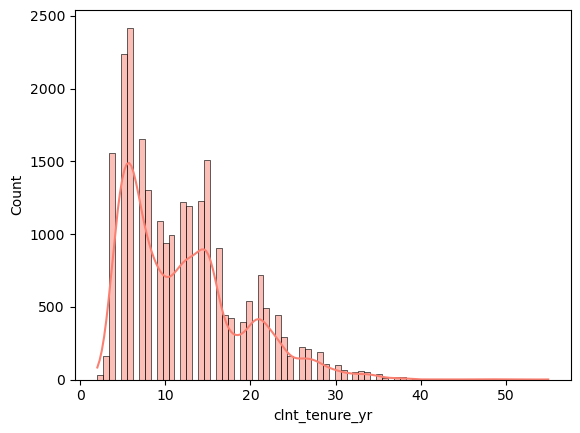

------------------------
distribution meassures for clnt_tenure_mnth
------------------------
"
    mean is 151.06018616908233
    median is 137.0
    mode is 58.0
    var is 6744.752647130114
    std is 82.12644304443067
    max is 669.0 and min is 33.0
    range is 636.0
    quantiles are 0.25     82.0
0.50    137.0
0.75    192.0
Name: clnt_tenure_mnth, dtype: float64
    


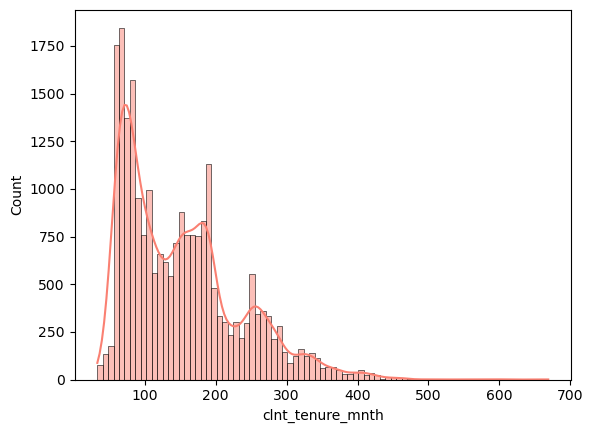

------------------------
distribution meassures for clnt_age
------------------------
"
    mean is 47.498427271954434
    median is 48.5
    mode is 58.5
    var is 240.92569359443544
    std is 15.521781263580396
    max is 96.0 and min is 17.0
    range is 79.0
    quantiles are 0.25    33.5
0.50    48.5
0.75    60.0
Name: clnt_age, dtype: float64
    


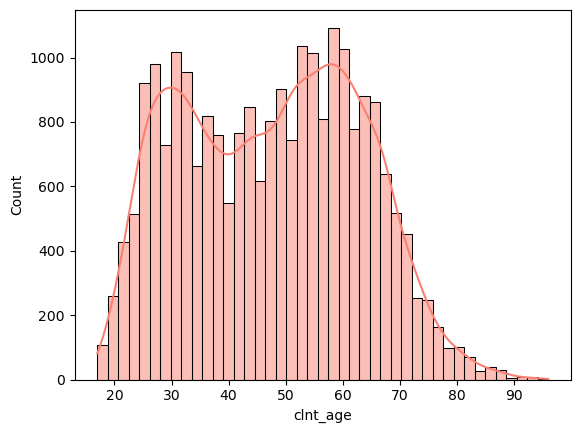

------------------------
distribution meassures for num_accts
------------------------
"
    mean is 2.2599141411994728
    median is 2.0
    mode is 2.0
    var is 0.29004612031637106
    std is 0.5385593006497715
    max is 7.0 and min is 2.0
    range is 5.0
    quantiles are 0.25    2.0
0.50    2.0
0.75    2.0
Name: num_accts, dtype: float64
    


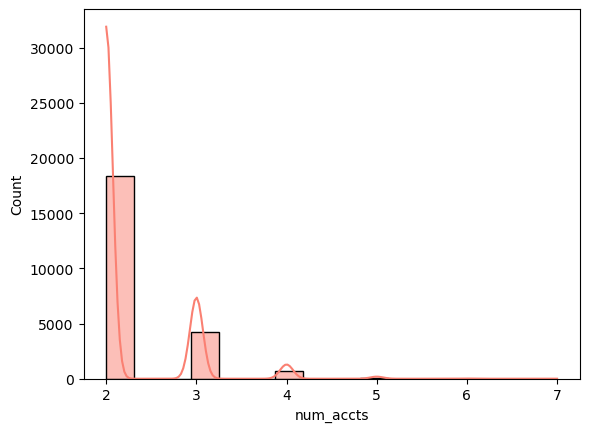

------------------------
distribution meassures for bal
------------------------
"
    mean is 150147.32665958258
    median is 66024.18
    mode is 31188.62
    var is 87501751881.4051
    std is 295806.95036020555
    max is 8292996.21 and min is 23789.61
    range is 8269206.6
    quantiles are 0.25     40123.355
0.50     66024.180
0.75    140606.045
Name: bal, dtype: float64
    


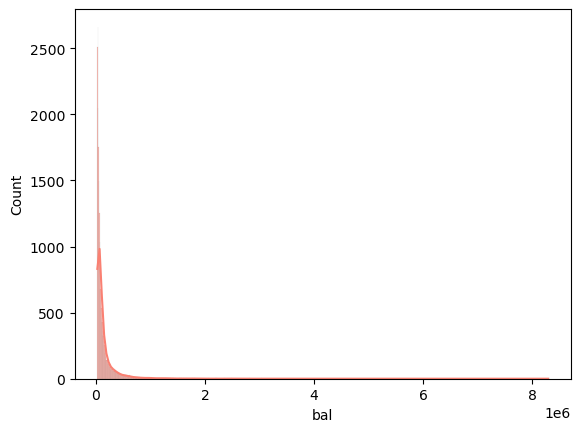

------------------------
distribution meassures for calls_6_mnth
------------------------
"
    mean is 3.1292132443575467
    median is 3.0
    mode is 6.0
    var is 4.772047595729862
    std is 2.184501681329145
    max is 6.0 and min is 0.0
    range is 6.0
    quantiles are 0.25    1.0
0.50    3.0
0.75    5.0
Name: calls_6_mnth, dtype: float64
    


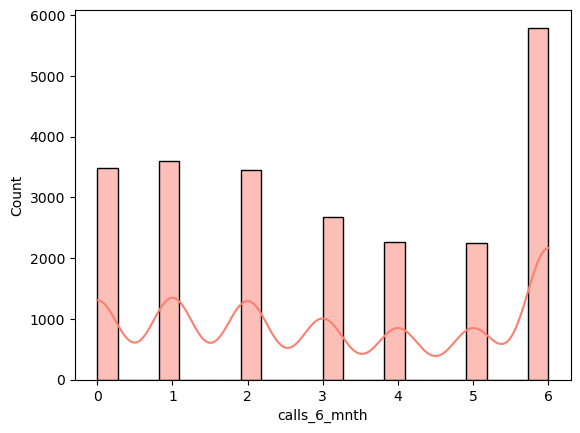

------------------------
distribution meassures for logons_6_mnth
------------------------
"
    mean is 6.166277043396948
    median is 6.0
    mode is 9.0
    var is 4.721989467237278
    std is 2.1730139132636217
    max is 9.0 and min is 3.0
    range is 6.0
    quantiles are 0.25    4.0
0.50    6.0
0.75    8.0
Name: logons_6_mnth, dtype: float64
    


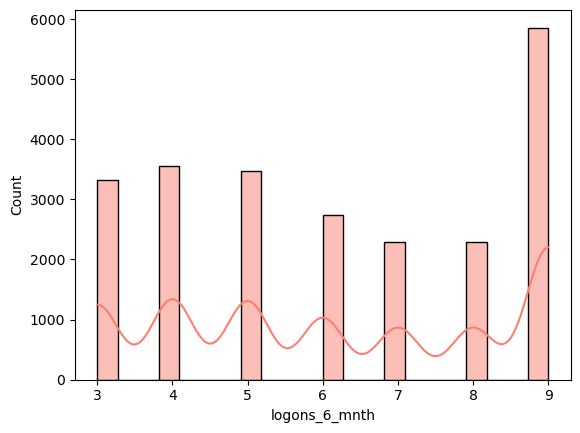

(       clnt_tenure_yr  clnt_tenure_mnth  clnt_age  num_accts        bal  \
 2                12.0             149.0      63.5        2.0  142642.26   
 4                 5.0              70.0      29.0        2.0   34254.54   
 7                13.0             162.0      56.5        2.0  324712.88   
 9                 6.0              74.0      61.5        2.0   39795.28   
 12               12.0             149.0      32.5        2.0   33807.15   
 ...               ...               ...       ...        ...        ...   
 50491             7.0              87.0      31.5        2.0  106927.60   
 50493            27.0             334.0      50.0        3.0  464879.31   
 50494            18.0             226.0      63.5        3.0   89726.65   
 50495            15.0             191.0      52.5        2.0   60344.67   
 50496            21.0             252.0      34.0        3.0  141808.05   
 
        calls_6_mnth  logons_6_mnth  
 2               5.0            8.0  
 4        

In [17]:
get_demographics(get_group(demo_df_clean)[0])
get_demographics(get_group(demo_df_clean)[1])

""
0
1
3
5
6
...
50478
50480
50485
50486


,Variation,gendr
0,Test,U
1,Test,M
3,Test,U
5,Test,F
6,Test,F
...,...,...
50478,Test,F
50480,Test,F
50485,Test,M
50486,Test,M


gendr
M    8977
F    8716
Name: count, dtype: int64
gendr
M    50.74%
F    49.26%
Name: proportion, dtype: object


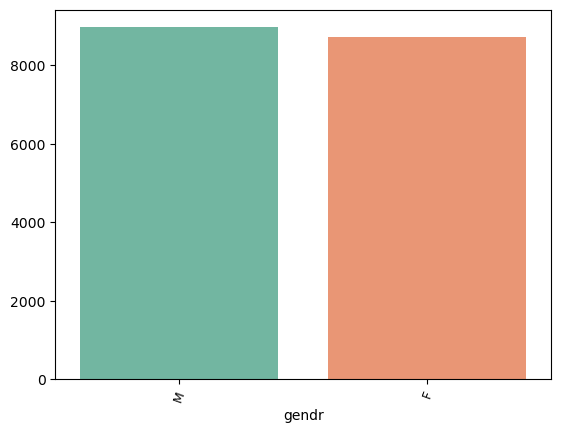

""
2
4
7
9
12
...
50479
50481
50482
50483


,Variation,gendr
2,Control,M
4,Control,U
7,Control,M
9,Control,U
12,Control,F
...,...,...
50479,Control,M
50481,Control,F
50482,Control,F
50483,Control,M


gendr
M    7970
F    7543
Name: count, dtype: int64
gendr
M    51.38%
F    48.62%
Name: proportion, dtype: object


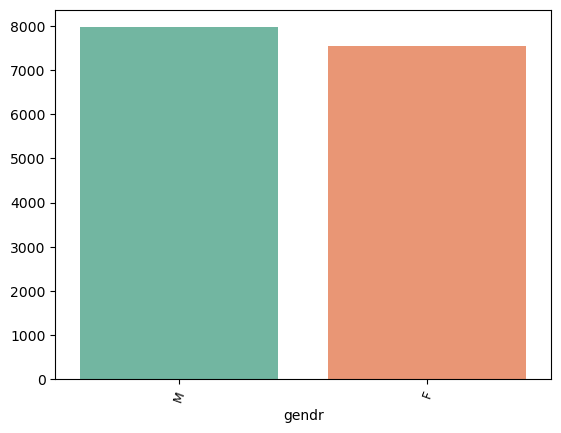

(Empty DataFrame
 Columns: []
 Index: [2, 4, 7, 9, 12, 14, 15, 20, 24, 27, 29, 31, 36, 38, 39, 40, 43, 45, 46, 49, 53, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 71, 72, 75, 76, 78, 81, 84, 86, 87, 88, 91, 92, 96, 97, 100, 103, 106, 109, 114, 117, 119, 120, 123, 124, 127, 129, 130, 131, 132, 135, 136, 137, 144, 145, 146, 147, 148, 149, 152, 154, 157, 158, 160, 161, 162, 163, 165, 170, 172, 173, 175, 176, 178, 181, 184, 188, 191, 192, 196, 197, 199, 204, 205, 206, 208, 209, 212, 213, 220, ...]
 
 [23527 rows x 0 columns],
       Variation gendr
 2       Control     M
 4       Control     U
 7       Control     M
 9       Control     U
 12      Control     F
 ...         ...   ...
 50479   Control     M
 50481   Control     F
 50482   Control     F
 50483   Control     M
 50484   Control     M
 
 [23527 rows x 2 columns])

In [18]:
get_demographics(get_group(clnt_gen_df_clean)[0])
get_demographics(get_group(clnt_gen_df_clean)[1])

In [17]:
def get_completion_data(df):
    completed_df = df[df['process_step']=='confirm'].sort_values(by='date_time', ascending=True)

    n_completions = completed_df['visit_id'].nunique() 
    n = df['visit_id'].nunique()

    return n_completions, n

In [18]:
function_df = get_group(final_web_df_clean)[0]
function_df['process_step'].value_counts()

process_step
start      56474
step_1     38768
step_2     30989
step_3     25894
confirm    25722
Name: count, dtype: int64

In [19]:
function_df = get_group(final_web_df_clean)[0]

completed_df = function_df[function_df['process_step']=='confirm']
completed_df['visit_id'].nunique() 
function_df['visit_id'].nunique()


37136

In [20]:
# Time Spent on Each Step
def time_spent_on_each_step(df):
    df = df.sort_values(by='date_time', ascending=True).copy()
    df['next_date_time'] = df.groupby('visit_id')['date_time'].shift(-1)
    df['duration'] = pd.to_datetime(df['next_date_time'])-pd.to_datetime(df['date_time'])
    df['duration']
    df.to_csv('duration.csv')
    return df['duration']

In [21]:
# Time Spent on Each Step
def time_spent_on_step(df, step):

    df = df.sort_values(by='date_time', ascending=True).copy()
    df['next_date_time'] = df.groupby('visit_id')['date_time'].shift(-1)
    filered = df[df['process_step'] == step]
    filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
    df.to_csv('step_duration.csv')
    return filered['duration']

In [33]:
def get_error_data(dataframe):
    """
    This function returns if a step has an error (meaning the previous step is the same as the next)
    It makes sure that the client_id and visit_id are the same (no errors between different clients/sessions)
    
    Parameters:
    step_dataframe (pd.DataFrame): it is important that this df has client_id, visit_id and process_step for this function to work

    Returns:
    error_rate (float)
    """
    step_to_int = {'start': 0,
                'step_1': 1,
                'step_2': 2,
                'step_3' : 3,
                'confirm': 4}
    step_dataframe = dataframe.copy()
    step_dataframe = step_dataframe.sort_values(by=['date_time', 'visit_id', 'client_id'], ascending=True)
    function_df = step_dataframe[['client_id', 'visit_id', 'process_step']].copy()

    function_df['step_int'] = function_df['process_step'].map(step_to_int)
    function_df['next_expected_step'] = function_df['step_int'].apply(lambda x: x+1 if x < 4 else 4 )
    #function_df = function_df.reset_index(drop=True)
    condition_client = function_df['client_id'] == function_df['client_id'].shift(-1)
    condition_visit = function_df['visit_id'] == function_df['visit_id'].shift(-1)
    condition_expected_step = function_df['next_expected_step'] != function_df['step_int'].shift(-1)

    function_df['step_validation'] = np.where(condition_client & condition_visit & condition_expected_step, 
                                    'error', 
                                    'ok')

    filtered = function_df[function_df['step_validation'] == 'error']
    n_errors = filtered['visit_id'].nunique()
    n = function_df['visit_id'].nunique()
    return n_errors, n, function_df


Completion ratio

H0: control_completion_rate >= test_completion_rate 
H1: control_completion_rate < test_completion_rate

In [24]:
#H0 test_completion = control_completion
#H1 test_completion != control_completion

test_results = get_completion_data(get_group(final_web_df_clean)[0])
print(f'test: {test_results} rate is {test_results[0]/test_results[1]}')
test_completions = test_results[0]
test_count = test_results[1]

control_results = get_completion_data(get_group(final_web_df_clean)[1])
print(f'control: {control_results} rate is {control_results[0]/control_results[1]}')
control_completions = control_results[0]
control_count = control_results[1]

# Example data
confirms = [test_completions, control_completions]      # number of completions
print(confirms)
users = [test_count, control_count]        # number of users
print(users)

# Run the test
z_stat, p_value = proportions_ztest(confirms, users, alternative='two-sided')

# Output
print(f"Z = {z_stat}, p = {p_value}")

test: (21731, 37136) rate is 0.5851734166307626
control: (16046, 32189) rate is 0.4984932740998478
[21731, 16046]
[37136, 32189]
Z = 22.85684118615931, p = 1.249501073264425e-115


In [25]:
#H0 test_completion >= control_completion
#H1 test_completion < control_completion

test_results = get_completion_data(get_group(final_web_df_clean)[0])
print(f'test: {test_results} rate is {test_results[0]/test_results[1]}')
test_completions = test_results[0]
test_count = test_results[1]

control_results = get_completion_data(get_group(final_web_df_clean)[1])
print(f'control: {control_results} rate is {control_results[0]/control_results[1]}')
control_completions = control_results[0]
control_count = control_results[1]

# Example data
confirms = [test_completions, control_completions]      # number of completions
print(confirms)
users = [test_count, control_count]        # number of users
print(users)

# Run the test
z_stat, p_value = proportions_ztest(confirms, users, alternative='smaller')

# Output
print(f"Z = {z_stat}, p = {p_value}")

test: (21731, 37136) rate is 0.5851734166307626
control: (16046, 32189) rate is 0.4984932740998478
[21731, 16046]
[37136, 32189]
Z = 22.85684118615931, p = 1.0


We failed to reject the null hypothesis, meaning test completion rate is statistically greater than control completion rate

In [ ]:
#H0 avg time step control = avg time step test
#h1 avg time step control != avg time step test

#significance level: 5%
test = time_spent_on_each_step(get_group(final_web_df_clean)[0]).dropna().dt.seconds
control = time_spent_on_each_step(get_group(final_web_df_clean)[1]).dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False) 

TtestResult(statistic=-2.4735228763852497, pvalue=0.01337956065967237, df=223686.74222769885)

In [28]:
test = time_spent_on_each_step(get_group(final_web_df_clean)[0]).dropna().dt.seconds.mean()
test

83.60300189750623

In [29]:
control = time_spent_on_each_step(get_group(final_web_df_clean)[1]).dropna().dt.seconds.mean()
control

81.46148661400339

We have gathered enough evidence to reject the null hypothesis, meaning avg time per step is different

In [ ]:
#H0 avg time step control >= avg time step test
#h1 avg time step control < avg time step test

#significance level: 5%
test = time_spent_on_each_step(get_group(final_web_df_clean)[0]).dropna().dt.seconds
control = time_spent_on_each_step(get_group(final_web_df_clean)[1]).dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False, alternative='less') 

TtestResult(statistic=-2.4735228763852497, pvalue=0.006689780329836185, df=223686.74222769885)

We have gathered enough evidence to reject the null hypothesis, meaning avg time per step is lower in control than in test

In [ ]:
#H0 avg time step control = avg time step test
#h1 avg time step control != avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'start').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'start').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False) 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=1.3285378084709352, pvalue=0.18400484193046876, df=69853.80902465513)

In [ ]:
#H0 avg time step control = avg time step test
#h1 avg time step control != avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_1').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_1').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False) 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=-8.47130410256885, pvalue=2.4863793401155754e-17, df=54328.46783092632)

In [ ]:
#H0 avg time step control <= avg time step test
#h1 avg time step control > avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_1').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_1').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False, alternative='greater') 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=-8.47130410256885, pvalue=1.0, df=54328.46783092632)

We failed to reject the null hypothesis, time spent in step 1 in control is lower than in test

In [ ]:
#H0 avg time step control = avg time step test
#h1 avg time step control != avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_2').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_2').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False) 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=2.0722440653615943, pvalue=0.03824845971927336, df=44278.01654815245)

In [ ]:
#H0 avg time step control <= avg time step test
#h1 avg time step control > avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_2').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_2').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False, alternative='greater') 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=2.0722440653615943, pvalue=0.01912422985963668, df=44278.01654815245)

We reject the null hypothesis, time spent in step 2 in control is higher than in test

In [ ]:
#H0 avg time step control = avg time step test
#h1 avg time step control != avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_3').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_3').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False) 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=3.1104131304924394, pvalue=0.0018694479550546612, df=44148.57027584107)

In [ ]:
#H0 avg time step control <= avg time step test
#h1 avg time step control > avg time step test

#significance level: 5%
test = time_spent_on_step(get_group(final_web_df_clean)[0],'step_3').dropna().dt.seconds
control = time_spent_on_step(get_group(final_web_df_clean)[1], 'step_3').dropna().dt.seconds

#H0: mu_price female <= mu_price male
#H1: mu_price female > mu_price male

alpha = 0.05


st.ttest_ind(control, test, equal_var=False, alternative = 'greater') 

C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])
C:\Users\Santi\AppData\Local\Temp\ipykernel_21528\3948345921.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filered['duration'] = pd.to_datetime(filered['next_date_time'])-pd.to_datetime(filered['date_time'])


TtestResult(statistic=3.1104131304924394, pvalue=0.0009347239775273306, df=44148.57027584107)

We reject the null hypothesis, meaning avg time spent in step 3 is greater in control than test

In [84]:
#H0 test_error = control_error
#H1 test_error != control_error

test_results = get_error_data(get_group(final_web_df_clean)[0])
print(f'test: {test_results} rate is {test_results[0]/test_results[1]}')
test_completions = test_results[0]
test_count = test_results[1]

control_results = get_error_data(get_group(final_web_df_clean)[1])
print(f'control: {control_results} rate is {control_results[0]/control_results[1]}')
control_completions = control_results[0]
control_count = control_results[1]

# Example data
confirms = [test_completions, control_completions]      # number of completions
print(confirms)
users = [test_count, control_count]        # number of users
print(users)

# Run the test
z_stat, p_value = proportions_ztest(confirms, users)

# Output
print(f"Z = {z_stat}, p = {p_value}")

test: (6255, 37136) rate is 0.16843494183541577
control: (7040, 32189) rate is 0.21870825437261177
[6255, 7040]
[37136, 32189]
Z = -16.767922696948474, p = 4.1889933438426435e-63


We failed to reject the null hypothesis, meaning test error rate and control error rate are not equal

In [44]:
#H0 test_error <= control_error
#H1 test_error > control_error

test_results = get_error_data(get_group(final_web_df_clean)[0])
print(f'test: {test_results[0],test_results[1]} rate is {test_results[0]/test_results[1]}')
test_completions = test_results[0]
test_count = test_results[1]

control_results = get_error_data(get_group(final_web_df_clean)[1])
print(f'control: {control_results[0],control_results[1]} rate is {control_results[0]/control_results[1]}')
control_completions = control_results[0]
control_count = control_results[1]

# Example data
confirms = [test_completions, control_completions]      # number of completions
print(confirms)
users = [test_count, control_count]        # number of users
print(users)

# Run the test
z_stat, p_value = proportions_ztest(confirms, users, alternative='larger')

# Output
print(f"Z = {z_stat}, p = {p_value}")

test: (6257, 37136) rate is 0.1684887979319259
control: (7048, 32189) rate is 0.21895678647985337
[6257, 7048]
[37136, 32189]
Z = -16.828028825626554, p = 1.0


We failed to reject the null hypothesis, meaning error rate in test is smaller than control

In [47]:
pwd = getpass()

In [48]:
conection = pymysql.connect

In [49]:
bd = "vanguard"
connection_string = 'mysql+pymysql://root:' + pwd + '@localhost/'+bd
engine = create_engine(connection_string)

In [51]:
duration_p =r'..\Data\Clean\final_web_df_tableau.csv'
demo_p = r'..\Data\Clean\demo_df_clean.csv'
generation_p = r'..\Data\Clean\clnt_gen_df_clean.csv'

duration = pd.read_csv(duration_p)
errors = get_error_data(final_web_df_clean)[2]
demographic = pd.read_csv(demo_p)
generation = pd.read_csv(generation_p)

In [52]:
duration.to_sql(name='visit_duration', con=engine)
errors.to_sql(name='visit_errors', con=engine)
demographic.to_sql(name='clients', con=engine)
generation.to_sql(name='client_generation', con=engine)

50488

In [ ]:
def get_tableau_csv():




    duration_error = pd.merge(duration, errors, how='left', on=['client_id', 'visit_id', 'process_step']) \
                       .drop(columns=['Unnamed: 0', 'step_int', 'next_expected_step'])

    demographic_merged = pd.merge(duration_error, demographic, how='left', on=['client_id', 'Variation']) \
                            .drop(columns=['Unnamed: 0'])

    tableau_merged = pd.merge(demographic_merged, generation, how='left', on=['client_id', 'Variation', 'gendr'])

    return tableau_merged

In [ ]:
get_tableau_csv().to_csv('analytics.csv')
